# ベースラインの構築

https://www.kaggle.com/sishihara/simple-lightgbm-kfold

In [3]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")         # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
np.set_printoptions(np.inf)
import time
import pickle
import gc
import os
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import seaborn as sns
import random 

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

In [6]:
POS_CASH_balance = import_data('../home credit/POS_CASH_balance.csv')
bureau_balance = import_data('../home credit/bureau_balance.csv')
application_train = import_data('../home credit/application_train.csv')
previous_application = import_data('../home credit/previous_application.csv')
installments_payments = import_data('../home credit/installments_payments.csv')
credit_card_balance = import_data('../home credit/credit_card_balance.csv')
application_test = import_data('../home credit/application_test.csv')
bureau = import_data('../home credit/bureau.csv')

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


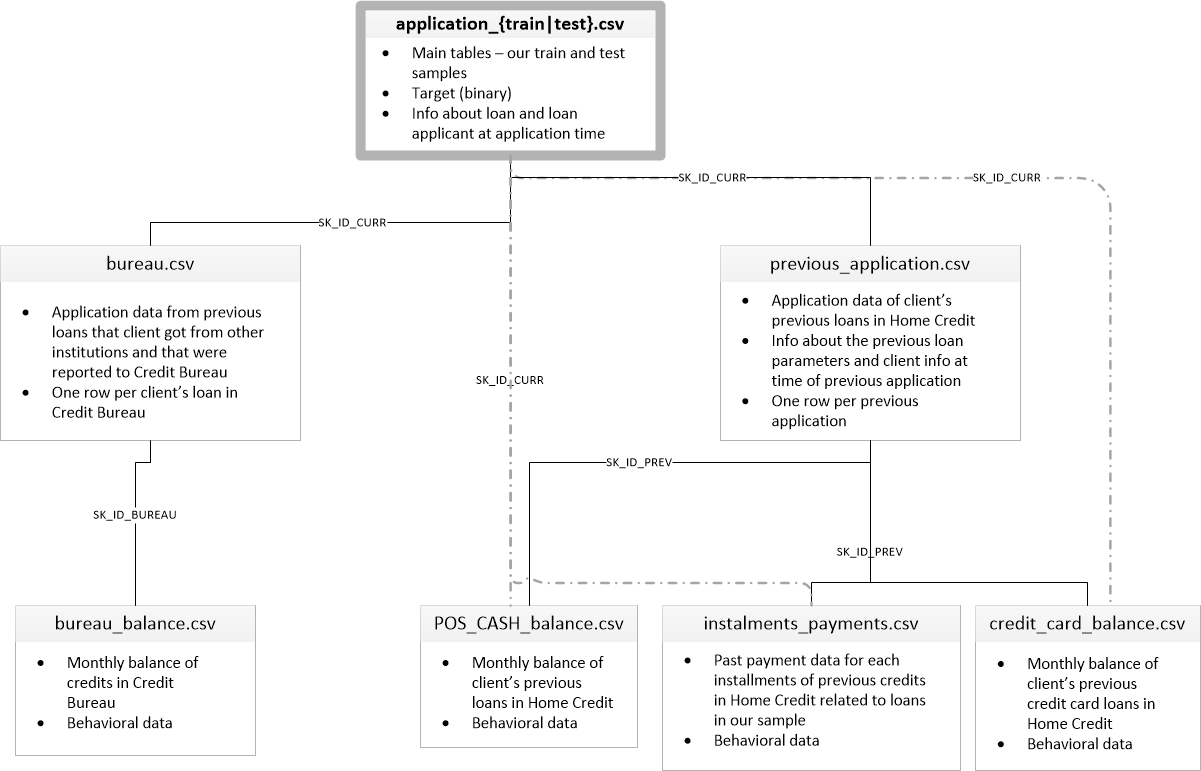

In [7]:
POS_CASH_balance.to_pickle('POS_CASH_balance.pickle')
bureau_balance.to_pickle('bureau_balance.pickle')
application_train.to_pickle('application_train.pickle')
previous_application.to_pickle('previous_application.pickle')
installments_payments.to_pickle('installments_payments.pickle')
credit_card_balance.to_pickle('credit_card_balance.pickle')
application_test.to_pickle('application_test.pickle')
bureau.to_pickle('bureau.pickle')

In [8]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


# 欠損を確認

In [9]:
def plot_miss(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['name', 'cnt']
    missing_df = missing_df[missing_df['cnt']>0]
    missing_df = missing_df.sort_values(by='cnt', ascending=False)
    ind = np.arange(missing_df.shape[0])
    width = 0.8
    fig, ax = plt.subplots(figsize=(12.5,17))
    rects = ax.barh(ind, missing_df.cnt.values, color='orange')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.name.values, rotation='horizontal')
    ax.set_xlabel("Missing values count")
    df_name = "df"
    ax.set_title("Number of missing values")
    plt.show()
# 欠損を可視化する関数

In [10]:
def tbl_miss(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_df
# 欠損の数と欠損のパーセンテージを見る関数

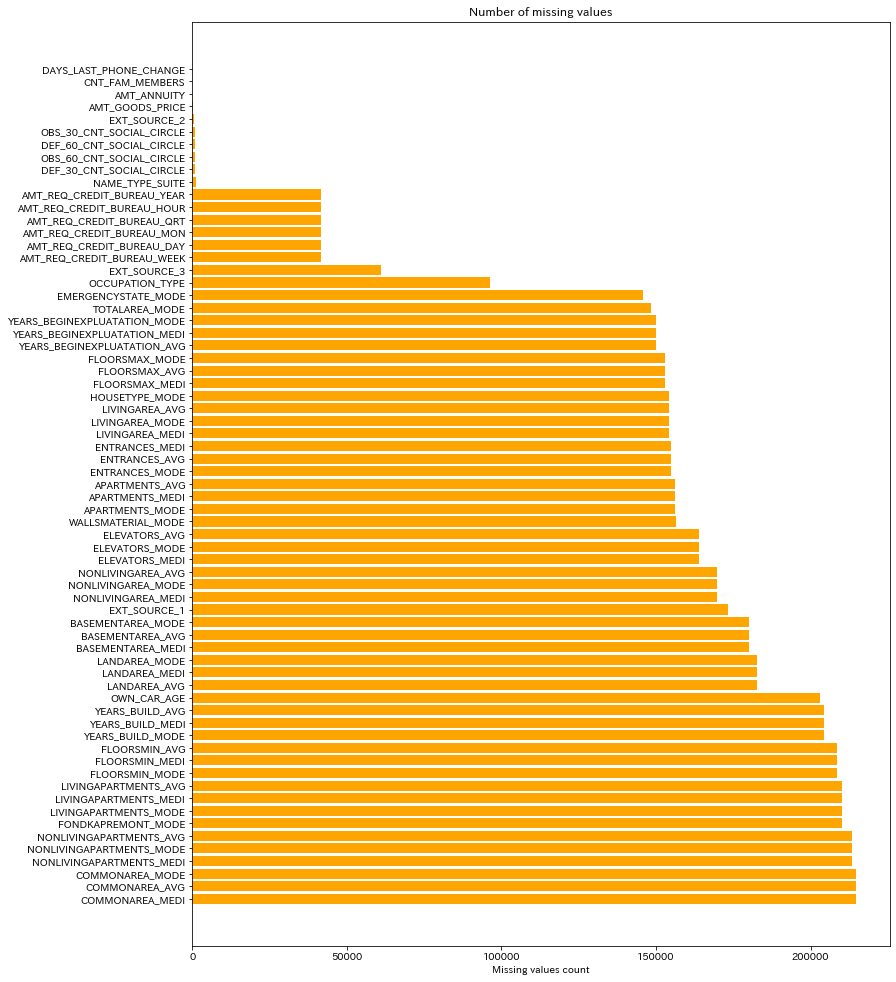

In [11]:
plot_miss(application_train)

# 数値変数とカテゴリ変数に分ける

In [12]:
def num_cat(df):
    num_f = df.dtypes[df.dtypes != 'category'].index
    cat_f = df.dtypes[df.dtypes == 'category'].index
    return num_f, cat_f

In [13]:
application_train_num, application_train_cat = num_cat(application_train)
application_train_num = application_train_num.drop(['SK_ID_CURR', 'TARGET'])

# ベースラインを作る

In [14]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier
import gc

# CSV Data Loading
data = application_train
test = application_test
prev = previous_application
buro = bureau

In [15]:
# Features Engineering
# ラベルエンコーディング
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])
    
gc.enable()

y = data['TARGET']
del data['TARGET']

prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

In [16]:
# previous_application,bureauを集計
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
for f_ in buro_cat_features:
    buro[f_], _ = pd.factorize(buro[f_])

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

In [17]:
# 結合
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

In [18]:
excluded_feats = ['SK_ID_CURR']
features = [f_ for f_ in data.columns if f_ not in excluded_feats]

In [19]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_indexes = []
    
    kf = KFold(n_splits=4, shuffle=True, random_state=6785)
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=250, 
                  early_stopping_rounds=100)
        
        
        tr_pred = model.predict(tr_x)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        print('  score Train : {:.6f}' .format(np.sqrt(roc_auc_score(tr_y, tr_pred))), 
              '  score Valid : {:.6f}' .format(np.sqrt(roc_auc_score(va_y, pred)))) 
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('Score : {:.6f}' .format(np.sqrt(roc_auc_score(train_y, pred_train))))
    return pred_train, preds_test, model

In [24]:
ts = time.time()
model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.1,
        num_leaves=123,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=15,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        importance_type='gain')
    
pred_train, preds_test, lgbm = predict_cv(model, data, y, test)
time.time() - ts

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's auc: 0.896552	training's binary_logloss: 0.194039	valid_1's auc: 0.770249	valid_1's binary_logloss: 0.245823
  score Train : 0.739398   score Valid : 0.717736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.88743	training's binary_logloss: 0.199276	valid_1's auc: 0.76401	valid_1's binary_logloss: 0.244511
  score Train : 0.736759   score Valid : 0.717512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's auc: 0.915975	training's binary_logloss: 0.185223	valid_1's auc: 0.761685	valid_1's binary_logloss: 0.244621
  score Train : 0.746797   score Valid : 0.717422
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's auc: 0.90898	training's binary_logloss: 0.189006	valid_1's auc: 0.767984	

101.69598770141602

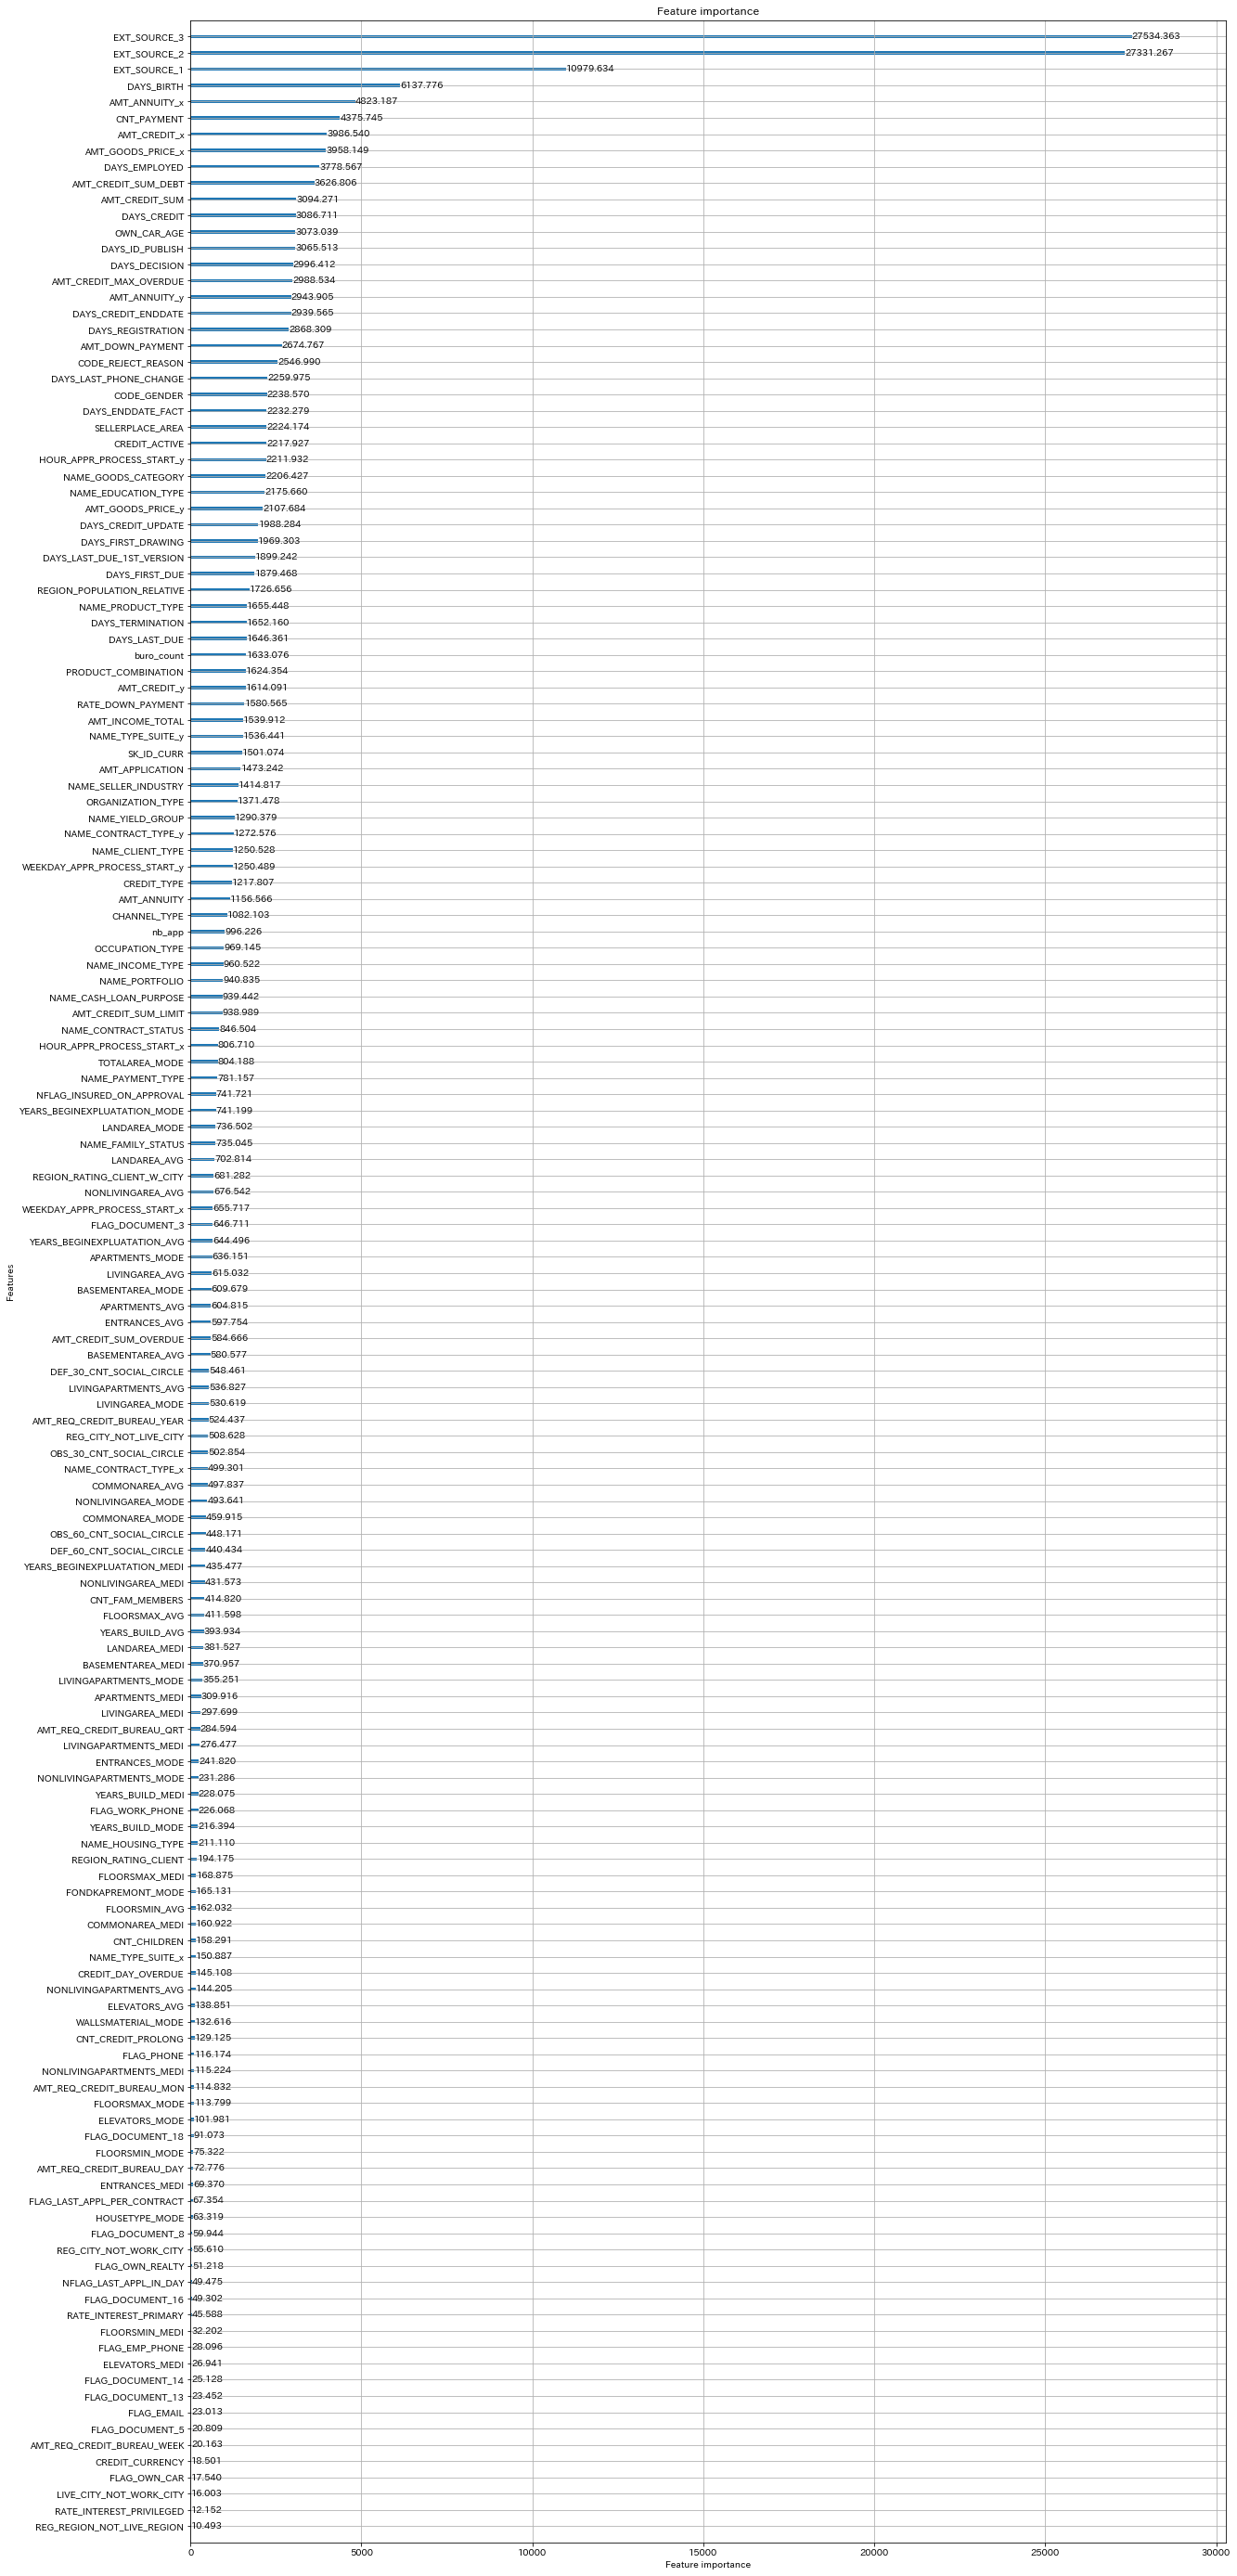

In [26]:
fig, ax = plt.subplots(figsize=(20, 50))
lgb.plot_importance(model, importance_type='gain', ax=ax)

In [45]:
test['TARGET'] = preds_test

test[['SK_ID_CURR', 'TARGET']].to_csv('baseline_submission.csv', index=False, float_format='%.8f')
#0.51824 #深すぎて過学習した説

# ついでにEDA

0.1868420970499256

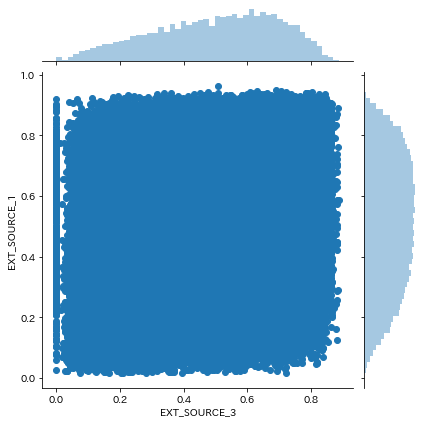

In [31]:
sns.jointplot('EXT_SOURCE_3', 'EXT_SOURCE_1', data=data)
data['EXT_SOURCE_3'].corr(data['EXT_SOURCE_1'])

0.21398383138073393

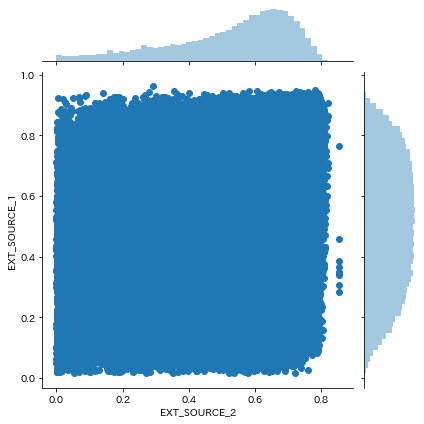

In [32]:
sns.jointplot('EXT_SOURCE_2', 'EXT_SOURCE_1', data=data)
data['EXT_SOURCE_2'].corr(data['EXT_SOURCE_1'])

0.10916593951071929

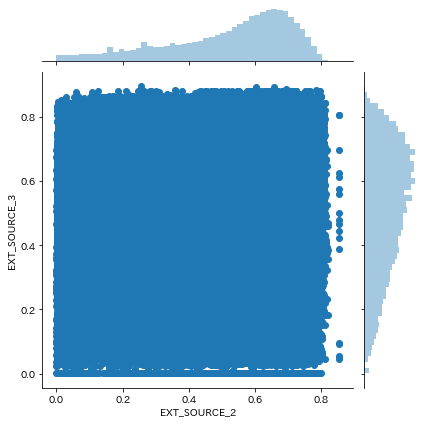

In [34]:
sns.jointplot('EXT_SOURCE_2', 'EXT_SOURCE_3', data=data)
data['EXT_SOURCE_2'].corr(data['EXT_SOURCE_3'])

-0.6006105704616098


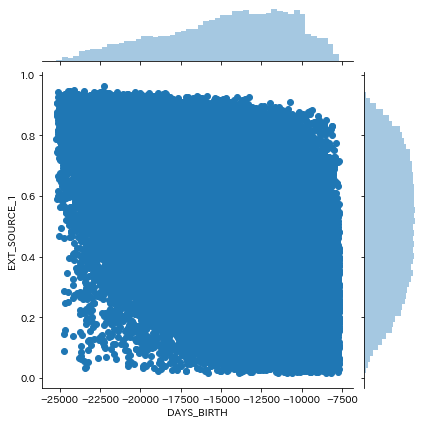

-0.09199582724085903


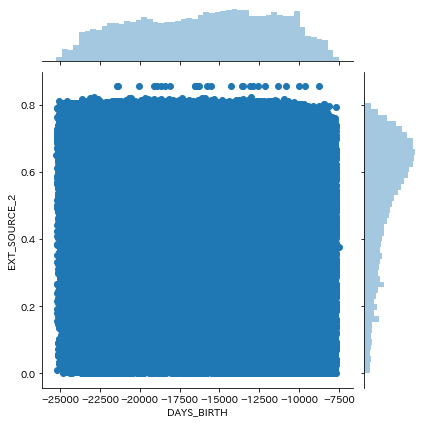

-0.20547662794827584


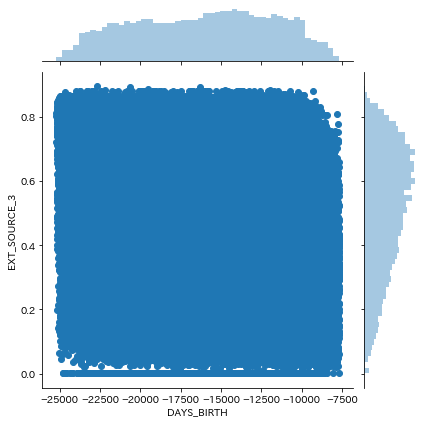

In [36]:
extra_source = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
for ext in extra_source:
    sns.jointplot('DAYS_BIRTH', ext, data=data)
    print(data['DAYS_BIRTH'].corr(data[ext]))
    plt.show()

In [44]:
importance = pd.DataFrame(model.feature_importances_, index=data.columns, columns=['importance']).sort_values('importance', ascending=False)
importance.head(30)

,importance
EXT_SOURCE_3,27534.363261
EXT_SOURCE_2,27331.267005
EXT_SOURCE_1,10979.634416
DAYS_BIRTH,6137.776179
AMT_ANNUITY_x,4823.186723
CNT_PAYMENT,4375.744757
AMT_CREDIT_x,3986.540377
AMT_GOODS_PRICE_x,3958.148649
DAYS_EMPLOYED,3778.566713
AMT_CREDIT_SUM_DEBT,3626.805579


In [49]:
importance_20 = importance.iloc[:20]

In [54]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()
    
# 前に使った関数を引っ張ってきました。

In [58]:
alldata = pd.concat([data, y], sort=False, axis=1)
alldata

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,buro_count,TARGET
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.000000,108131.945312,49156.199219,7997.141113,0.0,0.500000,-499.875000,0.0,8.0,1
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.000000,254350.125000,0.000000,202500.000000,0.0,0.500000,-816.000000,NaN,4.0,0
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.000000,94518.898438,0.000000,0.000000,0.0,0.000000,-532.000000,NaN,2.0,0
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.000000,146250.000000,0.000000,0.000000,0.0,0.000000,-783.000000,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,0.000000,990000.000000,448958.250000,0.000000,0.0,0.250000,-253.250000,58369.5,4.0,0
307509,456254,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,0.000000,45000.000000,0.000000,NaN,0.0,0.000000,-401.000000,0.0,1.0,1


In [59]:
plot_corr_matrix(alldata[importance_20], 20, 'TARGET')

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 960x960 with 0 Axes>